# Score-Based Generative Modeling on MNIST

<a target="_blank" href="https://colab.research.google.com/github/baptiste-pasquier/ensae-deep-learning/blob/main/notebooks/notebook_mnist.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install git+https://github.com/baptiste-pasquier/ensae-deep-learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pathlib import Path

import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from ensae_deep_learning.sampling import euler_maruyama_sampler, ode_sampler, pc_sampler
from ensae_deep_learning.sde import ScoreNet, diffusion_coeff, marginal_prob_std
from ensae_deep_learning.utils import (
    plot_dataset,
    plot_loss_history,
    plot_samples,
    print_sde_dim,
    run_training,
    summary_model,
)

device = "cuda"

In [3]:
sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

## 1. Data preprocessing

In [4]:
dataset_original = MNIST(
    "data/", train=True, transform=transforms.ToTensor(), download=True
)

In [5]:
# config = {
#     "model_name": "MNIST_1",
#     "image_size": (25, 25),
#     "in_channels": 1,
#     "channels": (32, 64, 128, 256),
#     "embed_dim": 256,
#     "n_epochs": 50,
#     "lr": 1e-4,
#     "batch_size": 64,
# }

# mean = torch.tensor([0.1307])
# std = torch.tensor([0.3081])

# normalize = transforms.Normalize(mean, std)
# unnormalize = transforms.Normalize((-mean / std), (1.0 / std))

# transformation = transforms.Compose(
#     [
#         transforms.CenterCrop(config["image_size"]),
#         transforms.ToTensor(),
#         normalize,
#     ]
# )
# dataset_transformed = MNIST(
#     "data/", train=True, transform=transformation, download=True
# )

In [6]:
config = {
    "model_name": "MNIST_2",
    "image_size": (25, 25),
    "in_channels": 1,
    "channels": (32, 64, 128, 256),
    "embed_dim": 256,
    "n_epochs": 50,
    "lr": 1e-4,
    "batch_size": 64,
}

mean = torch.tensor([0.1307])
std = torch.tensor([0.3081])

normalize = transforms.Normalize(mean, std)
unnormalize = transforms.Normalize((-mean / std), (1.0 / std))

transformation = transforms.Compose(
    [
        transforms.CenterCrop(config["image_size"]),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        normalize,
    ]
)
dataset_transformed = MNIST(
    "data/", train=True, transform=transformation, download=True
)

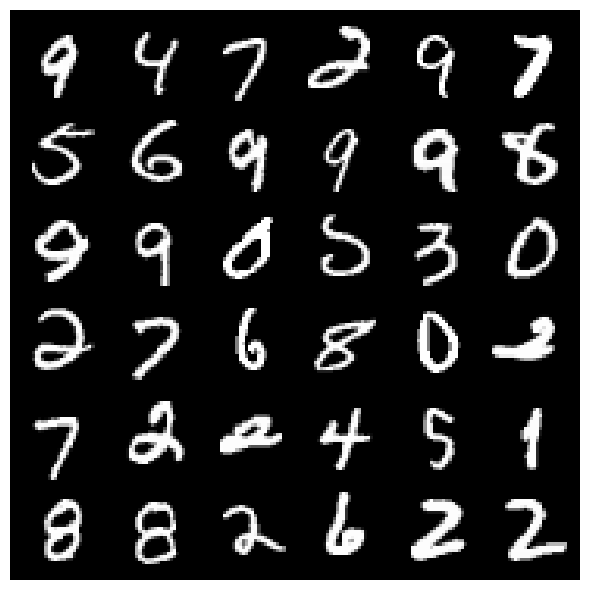

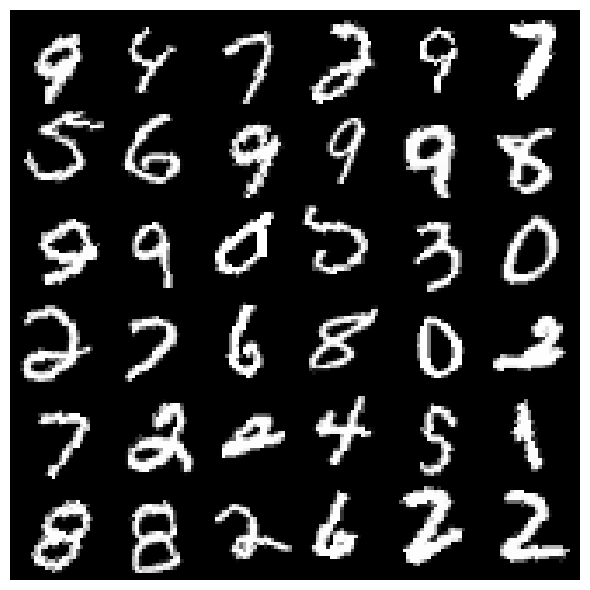

In [7]:
save_dir = Path("models", config["model_name"])
save_dir.mkdir(exist_ok=True, parents=True)

plot_dataset(dataset_original, save_dir, "dataset_original.pdf")
plot_dataset(dataset_transformed, save_dir, "dataset_transformed.pdf", unnormalize)

## 2. Training

In [8]:
score_model = torch.nn.DataParallel(
    ScoreNet(
        in_channels=config["in_channels"],
        marginal_prob_std=marginal_prob_std_fn,
        channels=config["channels"],
        embed_dim=config["embed_dim"],
    )
)
score_model = score_model.to(device)

summary_model(score_model, config)

c:\Users\Baptiste\AppData\Local\pypoetry\Cache\virtualenvs\ensae-deep-learning-s5kX7eX2-py3.11\Lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Baptiste\AppData\Local\pypoetry\Cache\virtualenvs\ensae-deep-learning-s5kX7eX2-py3.11\Lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [64, 1, 25, 25]           --
├─ScoreNet: 1-1                                    [64, 1, 25, 25]           --
│    └─Sequential: 2-1                             [64, 256]                 --
│    │    └─GaussianFourierProjection: 3-1         [64, 256]                 (128)
│    │    └─Linear: 3-2                            [64, 256]                 65,792
│    └─Conv2d: 2-2                                 [64, 32, 23, 23]          288
│    └─Dense: 2-3                                  [64, 32, 1, 1]            --
│    │    └─Linear: 3-3                            [64, 32]                  8,224
│    └─GroupNorm: 2-4                              [64, 32, 23, 23]          64
│    └─Conv2d: 2-5                                 [64, 64, 11, 11]          18,432
│    └─Dense: 2-6                                  [64, 64, 1, 1]            --
│    │    └─Linear: 

In [9]:
print_sde_dim(config)

25
23
11
5
2
2
5
11
23
25


In [10]:
loss_history = run_training(
    score_model,
    dataset_transformed,
    config,
    marginal_prob_std_fn,
    save_dir,
    device,
)

Loading previous training...


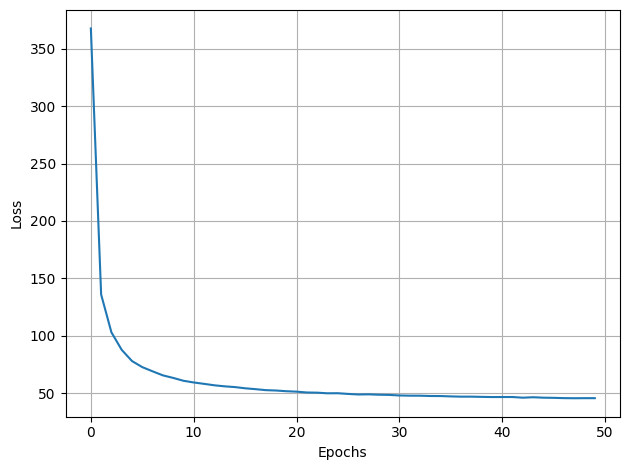

In [11]:
plot_loss_history(loss_history, save_dir)

## 3. Sampling

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


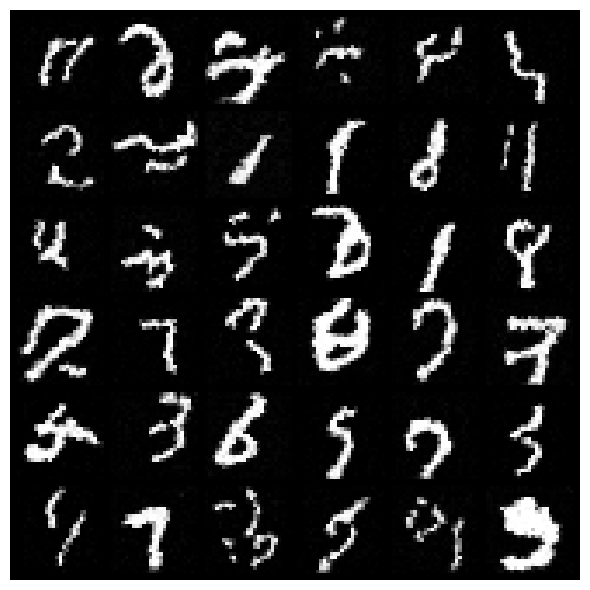

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


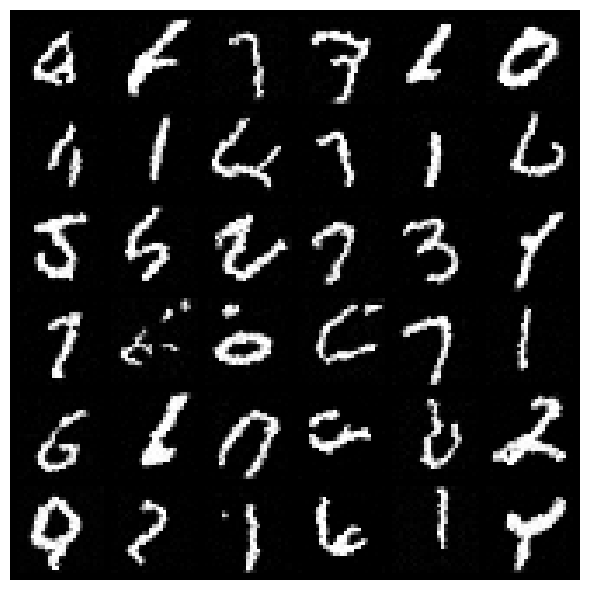

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of function evaluations: 362


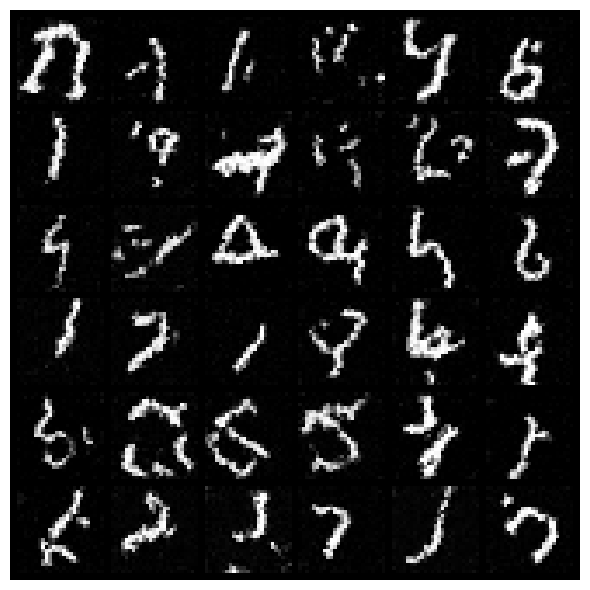

In [12]:
# Load the pre-trained checkpoint from disk.
ckpt = torch.load(Path(save_dir, "model.pth"), map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 36
for sampler in [
    euler_maruyama_sampler,
    pc_sampler,
    ode_sampler,
]:
    # Generate samples using the specified sampler.
    samples = sampler(
        score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        config,
        sample_batch_size,
        device=device,
    )
    samples = unnormalize(samples)

    plot_samples(samples, sampler, save_dir)